In [1]:
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import nd2
import numpy as np
path = 'D:\\iScat data processing project\Data\\2024_11_11\\Metasurface\\Chip_02\\Metasurface 01\\Brightfield'
z_stack_path = path+'\\02_01_BF.nd2'
f1_path = path+'\\Captured Cy5.tif'
f2_path = path+'\\Captured FITC.tif'
f3_path = path+'\\Captured TRITC.tif'
my_array = nd2.imread(z_stack_path)
f1_img =  Image.open(f1_path)
f2_img =  Image.open(f2_path)
f3_img =  Image.open(f3_path)

In [39]:
import numpy as np
from scipy import ndimage
from scipy.optimize import curve_fit
import cv2

class ParticleDetector:
    def __init__(self):
        pass
    
    def detect_particles(self, image, particle_size, intensity_threshold=3.0):
        """
        Detect particles in the image using ComDet-like algorithm.
        
        Parameters:
        -----------
        image : np.ndarray
            Input image
        particle_size : float
            Approximate particle size in pixels
        intensity_threshold : float
            Intensity threshold in standard deviations (default: 3.0)
            
        Returns:
        --------
        detections : list
            List of dictionaries containing detection information
        enhanced_image : np.ndarray
            Image after Mexican hat filtering
        """
        # Create Mexican hat filter (difference of Gaussians)
        sigma = particle_size / 2.35  # Convert FWHM to sigma
        kernel_size = int(6 * sigma)  # 3 sigma on each side
        if kernel_size % 2 == 0:
            kernel_size += 1
            
        kernel = self._create_mexican_hat_kernel(kernel_size, sigma)
        
        # Convolve image with the filter
        enhanced_image = cv2.filter2D(image.astype(float), -1, kernel)
        
        # Get threshold using histogram analysis
        threshold = self._get_threshold(enhanced_image, intensity_threshold)
        
        # Create binary mask
        binary_mask = enhanced_image > threshold
        
        # Remove small objects and fill holes
        binary_mask = ndimage.binary_opening(binary_mask)
        binary_mask = ndimage.binary_closing(binary_mask)
        
        # Label connected components
        labeled_mask, num_features = ndimage.label(binary_mask)
        
        # Find properties of each detected particle
        print(num_features)
        detections = []
        for i in range(1, num_features + 1):
            particle_mask = labeled_mask == i
            props = self._analyze_particle(image, particle_mask)
            if props is not None:
                detections.append(props)
        
        return detections, enhanced_image
    
    def _create_mexican_hat_kernel(self, size, sigma):
        """Create Mexican hat (difference of Gaussians) kernel."""
        x = np.arange(-(size//2), size//2 + 1)
        y = np.arange(-(size//2), size//2 + 1)
        xx, yy = np.meshgrid(x, y)
        
        # Create two Gaussians with different widths
        gaussian1 = np.exp(-(xx**2 + yy**2)/(2*sigma**2))
        gaussian2 = np.exp(-(xx**2 + yy**2)/(2*(1.6*sigma)**2))
        
        # Create Mexican hat kernel
        kernel = gaussian1/gaussian1.sum() - gaussian2/gaussian2.sum()
        return kernel
    
    def _gaussian(self, x, amplitude, mean, std_dev):
        """Gaussian function for fitting."""
        return amplitude * np.exp(-(x - mean)**2 / (2 * std_dev**2))
    
    def _get_threshold(self, image, intensity_threshold):
        """
        Get threshold using histogram analysis and Gaussian fitting.
        """
        # Create histogram
        hist, bin_edges = np.histogram(image.ravel(), bins='auto')
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        # Find initial parameters for Gaussian fit
        max_count_idx = np.argmax(hist)
        amplitude = hist[max_count_idx]
        mean = bin_centers[max_count_idx]
        std_dev = np.std(image)
        
        try:
            # Fit Gaussian to histogram
            popt, _ = curve_fit(self._gaussian, bin_centers, hist, 
                              p0=[amplitude, mean, std_dev])
            _, mean, std_dev = popt
            
            # Calculate threshold
            threshold = mean + intensity_threshold * std_dev
            
        except RuntimeError:
            # If fitting fails, use simple statistics
            threshold = np.mean(image) + intensity_threshold * np.std(image)
        
        return threshold
    
    def _analyze_particle(self, original_image, particle_mask):
        """
        Analyze individual particle properties.
        """
        # Get bounding box
        coords = np.where(particle_mask)
        if len(coords[0]) == 0:
            return None
            
        y_min, y_max = np.min(coords[0]), np.max(coords[0])
        x_min, x_max = np.min(coords[1]), np.max(coords[1])
        
        # Calculate centroid
        centroid_y = np.mean(coords[0])
        centroid_x = np.mean(coords[1])
        
        # Calculate background intensity from perimeter
        bg_mask = np.zeros_like(particle_mask, dtype=bool)
        bg_mask[y_min-1:y_max+2, x_min-1:x_max+2] = True
        bg_mask[y_min:y_max+1, x_min:x_max+1] = False
        
        # Ensure we're within image bounds
        bg_mask = bg_mask & (np.arange(bg_mask.shape[0])[:,None] >= 0) & \
                           (np.arange(bg_mask.shape[0])[:,None] < original_image.shape[0]) & \
                           (np.arange(bg_mask.shape[1])[None,:] >= 0) & \
                           (np.arange(bg_mask.shape[1])[None,:] < original_image.shape[1])
        
        if np.any(bg_mask):
            bg_intensity = np.mean(original_image[bg_mask])
        else:
            bg_intensity = 0
            
        # Calculate integrated intensity
        total_intensity = np.sum(original_image[particle_mask])
        n_pixels = np.sum(particle_mask)
        integrated_intensity = total_intensity - bg_intensity * n_pixels
        
        return {
            'centroid': (centroid_x, centroid_y),
            'bbox': (x_min, y_min, x_max, y_max),
            'area': n_pixels,
            'integrated_intensity': integrated_intensity,
            'background': bg_intensity
        }

In [40]:
import numpy as np
from skimage import io

# Create detector instance
detector = ParticleDetector()

# Load image
image = io.imread(f1_path)

# Detect particles
detections, enhanced_image = detector.detect_particles(
    image,
    particle_size=4,  # approximate particle size in pixels
    intensity_threshold=10  # detection threshold in standard deviations
)

4067


KeyboardInterrupt: 

In [45]:
filtered_data = [item for item in detections if item['integrated_intensity'] > 0]

# Print the filtered list
print(len(filtered_data))

4061


In [41]:
# Print results
for i, detection in enumerate(detections):
    print(f"Particle {i+1}:")
    print(f"  Position: {detection['centroid']}")
    print(f"  Integrated Intensity: {detection['integrated_intensity']}")
    print(f"  Area: {detection['area']} pixels")

Particle 1:
  Position: (1002.5, 1.3333333333333333)
  Integrated Intensity: 254.25
  Area: 6 pixels
Particle 2:
  Position: (1510.5, 1.6666666666666667)
  Integrated Intensity: 1715.272727272727
  Area: 12 pixels
Particle 3:
  Position: (2045.5, 1.6666666666666667)
  Integrated Intensity: 2006.636363636364
  Area: 12 pixels
Particle 4:
  Position: (558.7, 6.15)
  Integrated Intensity: 2881.3846153846152
  Area: 20 pixels
Particle 5:
  Position: (901.0, 5.0)
  Integrated Intensity: 204.375
  Area: 5 pixels
Particle 6:
  Position: (314.0, 7.5)
  Integrated Intensity: 2887.3846153846152
  Area: 22 pixels
Particle 7:
  Position: (796.5, 6.5)
  Integrated Intensity: 660.8000000000002
  Area: 12 pixels
Particle 8:
  Position: (943.5172413793103, 7.896551724137931)
  Integrated Intensity: 6502.900000000001
  Area: 29 pixels
Particle 9:
  Position: (1098.0, 6.5)
  Integrated Intensity: 423.7777777777778
  Area: 8 pixels
Particle 10:
  Position: (1110.0, 9.5)
  Integrated Intensity: 14263.3529

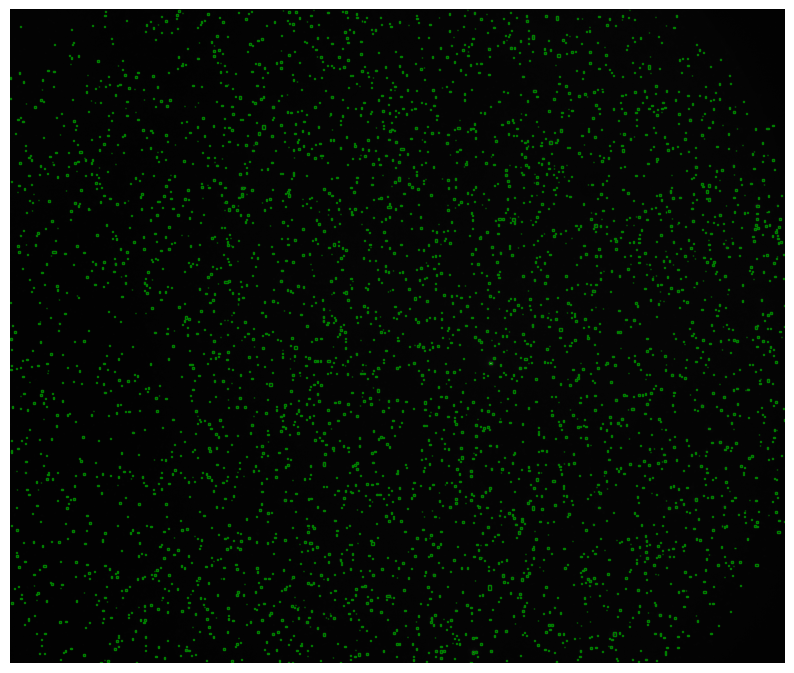

In [34]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import tifffile  # for reading .tif files

def visualize_bboxes_matplotlib(image_path, bbox_list):
    """
    Visualize bounding boxes on an image using matplotlib
    
    Parameters:
    image_path (str): Path to the image file
    bbox_list (list): List of dictionaries containing bbox information
    """
    # Read the image using tifffile
    img = tifffile.imread(image_path)
    
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Display the image
    ax.imshow(img, cmap='gray')
    
    # Draw each bounding box
    for item in bbox_list:
        # Extract bbox coordinates
        x1, y1, x2, y2 = item['bbox']
        width = x2 - x1
        height = y2 - y1
        
        # Create rectangle patch
        rect = Rectangle((x1, y1), width, height,
                        fill=False,
                        edgecolor='g',
                        linewidth=1)
        
        # Add rectangle to plot
        ax.add_patch(rect)
        
    # Remove axes ticks for cleaner visualization
    plt.axis('off')
    
    # Show plot
    plt.show()

# Usage

try:
    visualize_bboxes_matplotlib(f1_path, detections)
except Exception as e:
    print(f"Error: {str(e)}")

d:\anaconda3\envs\venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


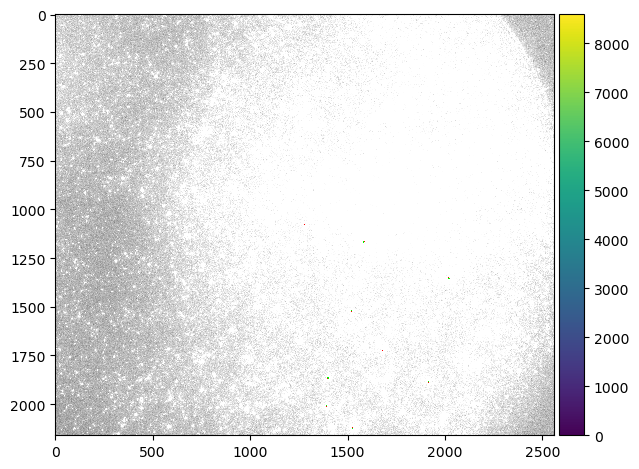

Particle at (1278.7, 1078.9)
Area: 5494396.0
Integrated intensity: 215270412.5
Particle at (1586.8, 1168.5)
Area: 61.0
Integrated intensity: 239624.9
Particle at (2020.5, 1352.7)
Area: 46.0
Integrated intensity: 36342.8
Particle at (1520.8, 1524.8)
Area: 45.0
Integrated intensity: 40678.0
Particle at (1681.7, 1727.9)
Area: 45.0
Integrated intensity: 34285.2
Particle at (1398.8, 1868.2)
Area: 47.0
Integrated intensity: 52433.5
Particle at (1915.0, 1888.6)
Area: 42.0
Integrated intensity: 24165.6
Particle at (1391.0, 2012.1)
Area: 45.0
Integrated intensity: 51076.0
Particle at (1528.9, 2123.4)
Area: 62.0
Integrated intensity: 86799.8


In [61]:
import numpy as np
from scipy import ndimage, stats
from skimage import filters, measure
from scipy.optimize import curve_fit
import cv2

class ParticleDetector:
    def __init__(self):
        """Initialize the particle detector"""
        self.results = []
        
    def _create_mexican_hat_kernel(self, size, sigma):
        """Create a 2D Mexican hat (Laplacian of Gaussian) kernel
        
        Args:
            size (int): Kernel size in pixels
            sigma (float): Standard deviation of the Gaussian
            
        Returns:
            numpy.ndarray: 2D Mexican hat kernel
        """
        x = np.linspace(-size//2, size//2, size)
        y = np.linspace(-size//2, size//2, size)
        X, Y = np.meshgrid(x, y)
        R2 = X**2 + Y**2
        
        # Mexican hat formula
        kernel = (1 - R2/(2*sigma**2)) * np.exp(-R2/(2*sigma**2))
        kernel = kernel - np.mean(kernel)  # Ensure kernel sums to zero
        return kernel
    
    def _gaussian_fit(self, hist, bins):
        """Fit Gaussian to histogram data
        
        Args:
            hist (numpy.ndarray): Histogram counts
            bins (numpy.ndarray): Bin edges
            
        Returns:
            tuple: (mean, std) of fitted Gaussian
        """
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        def gaussian(x, amp, mu, sigma):
            return amp * np.exp(-(x - mu)**2 / (2*sigma**2))
        
        # Initial guess
        p0 = [np.max(hist), bin_centers[np.argmax(hist)], np.std(bin_centers)]
        
        try:
            popt, _ = curve_fit(gaussian, bin_centers, hist, p0=p0)
            return popt[1], popt[2]  # mean and std
        except:
            # Fallback to simple statistics if fitting fails
            return np.mean(bin_centers), np.std(bin_centers)
    
    def _calculate_integrated_intensity(self, image, bbox):
        """Calculate integrated intensity for a particle
        
        Args:
            image (numpy.ndarray): Original image
            bbox (tuple): Bounding box (min_row, min_col, max_row, max_col)
            
        Returns:
            float: Integrated intensity value
        """
        min_row, min_col, max_row, max_col = bbox
        # Get the rectangle region
        region = image[min_row:max_row+1, min_col:max_col+1]
        
        # Calculate background from perimeter
        perimeter = np.concatenate([
            region[0, :],  # top
            region[-1, :],  # bottom
            region[1:-1, 0],  # left
            region[1:-1, -1]  # right
        ])
        bg_intensity = np.mean(perimeter)
        
        # Calculate integrated intensity
        total_intensity = np.sum(region)
        n_pixels = region.size
        
        return total_intensity - (bg_intensity * n_pixels)
    
    def detect_particles(self, image, particle_size, intensity_threshold=3.0, roi=None):
        """Detect particles in the image
        
        Args:
            image (numpy.ndarray): Input image
            particle_size (int): Approximate particle size in pixels
            intensity_threshold (float): Threshold in standard deviations
            roi (tuple): Region of interest (min_row, min_col, max_row, max_col)
            
        Returns:
            list: List of dictionaries containing particle properties
        """
        # Create mexican hat kernel
        kernel_size = int(2 * particle_size + 1)
        kernel = self._create_mexican_hat_kernel(kernel_size, particle_size/2)
        
        # Convolve image with kernel
        convolved = cv2.filter2D(image.astype(float), -1, kernel)
        
        # Calculate threshold using histogram analysis
        hist, bins = np.histogram(convolved.flatten(), bins='auto')
        mean, std = self._gaussian_fit(hist, bins)
        threshold = mean + intensity_threshold * std
        
        # Create binary mask
        binary = convolved > threshold
        
        # Morphological operations
        binary = ndimage.binary_dilation(binary)
        binary = ndimage.binary_erosion(binary)
        
        # Label connected components
        labels = measure.label(binary)
        regions = measure.regionprops(labels, intensity_image=image)
        
        results = []
        for region in regions:
            # Get centroid and bounding box
            y, x = region.centroid
            bbox = region.bbox
            
            # Skip if outside ROI
            if roi is not None:
                min_row, min_col, max_row, max_col = roi
                if (y < min_row or y > max_row or 
                    x < min_col or x > max_col):
                    continue
            
            # Calculate integrated intensity
            int_intensity = self._calculate_integrated_intensity(image, bbox)
            
            # Store results
            particle = {
                'x': x,
                'y': y,
                'bbox': bbox,
                'area': region.area,
                'integrated_intensity': int_intensity,
                'mean_intensity': region.mean_intensity
            }
            results.append(particle)
        
        self.results = results
        return results
    
    def get_particle_image(self, image, particle_size=3):
        """Create visualization of detected particles
        
        Args:
            image (numpy.ndarray): Original image
            particle_size (int): Size of particle markers
            
        Returns:
            numpy.ndarray: Image with marked particles
        """
        output = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        
        for particle in self.results:
            x, y = int(particle['x']), int(particle['y'])
            cv2.rectangle(output, 
                         (int(particle['bbox'][1]), int(particle['bbox'][0])),
                         (int(particle['bbox'][3]), int(particle['bbox'][2])),
                         (0, 255, 0), 1)
            cv2.circle(output, (x, y), particle_size, (255, 0, 0), -1)
            
        return output

# Example usage:

import numpy as np
from skimage import io

# Load image
image = io.imread(f1_path)

# Create detector
detector = ParticleDetector()

# Detect particles
particles = detector.detect_particles(
    image,
    particle_size=4,  # Approximate particle size in pixels
    intensity_threshold=10,  # Number of standard deviations above background
    roi=None  # Optional ROI as (min_row, min_col, max_row, max_col)
)

# Visualize results
result_image = detector.get_particle_image(image)
io.imshow(result_image)
io.show()

# Print results
for particle in particles:
    print(f"Particle at ({particle['x']:.1f}, {particle['y']:.1f})")
    print(f"Area: {particle['area']}")
    print(f"Integrated intensity: {particle['integrated_intensity']:.1f}")


In [17]:
with nd2.ND2File(z_stack_path) as f:
    print(f.shape)
f.close()

(201, 2160, 2560)


In [3]:
a = np.asarray(f2_img)
print(a.max())
print(a.min())

14036
287


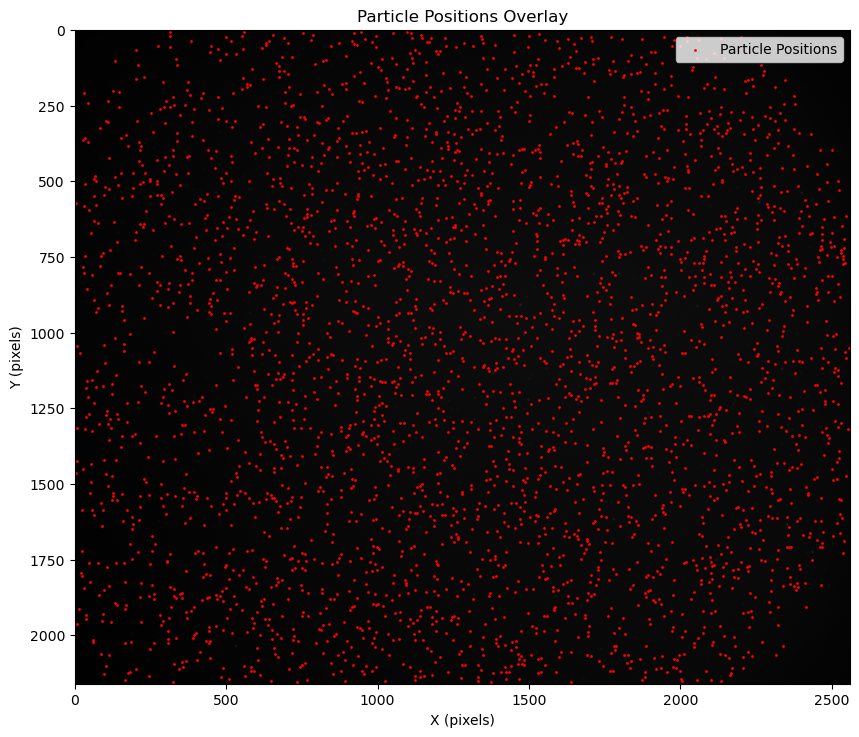

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
points_path = path+"\\Results.csv"  # Replace with your CSV file path
data = pd.read_csv(points_path)

# Extract the x and y positions (first two columns)
x_positions = data['X_(px)']
y_positions = data['Y_(px)']

# Load the image as a numpy array (replace 'image_array' with your actual image array)
image_array = a.copy()  # Replace with your actual NumPy image array

# Create a plot
plt.figure(figsize=(10, 10))
plt.imshow(image_array, cmap='gray')
plt.scatter(x_positions, y_positions, c='red', s=1, label='Particle Positions')

# Adjust plot settings
plt.title('Particle Positions Overlay')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.legend()
plt.show()


In [6]:
(2560*2160)-110*(224*224)

10240

In [10]:
11*9

99

In [9]:
2160/224

9.642857142857142

In [31]:
110*200*8


176000

In [28]:
a.shape

(2160, 2560)

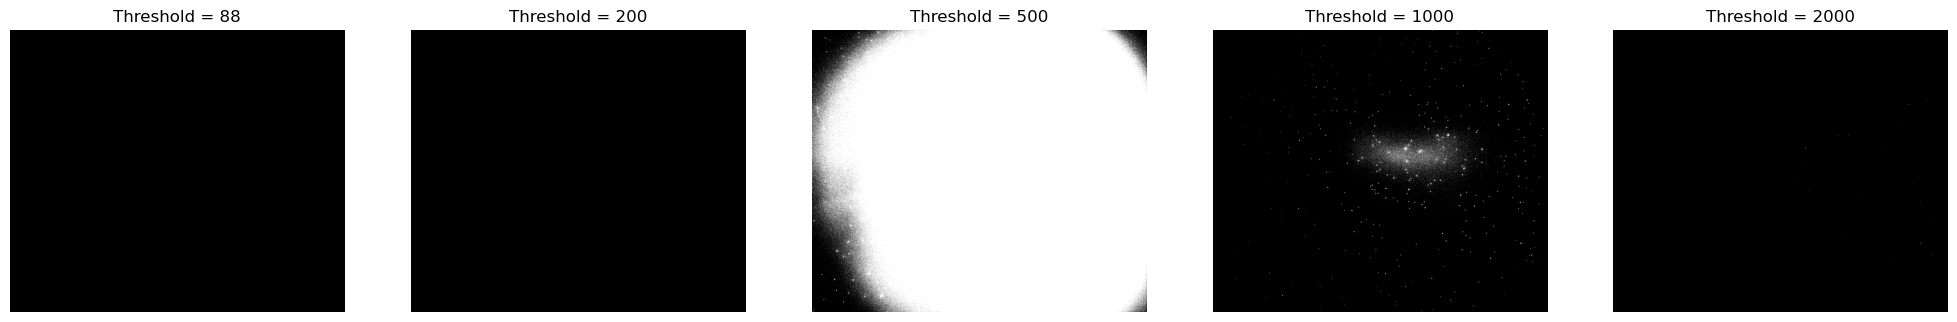

In [27]:
thresholds = [88,200,500,1000,2000]
fig, ax = plt.subplots(1,5,figsize=(25, 25))  
for i,threshold in enumerate(thresholds):
    b = a.copy()
    b[a>threshold]=255
    b[a<=threshold]=0
    ax[i].imshow(b,cmap='gray')
    ax[i].axis('off')
    ax[i].set_title('Threshold = '+str(threshold))
plt.show() 

In [7]:
my_array.shape

(201, 2160, 2560)

In [ ]:
from skimage.io import imread, imshow
from skimage.filters import threshold_otsu
from skimage.color import label2rgb
from numpy import percentile
import matplotlib.pyplot as plt

from spade.detection_2d import spade2d
from spade.shapes.examples import potatoids5x5_smallest4px


# Load the example image.
image = imread("example_2d.png")

# Separate cell image from background, using by Otsu's thresholding method.
cell = image > threshold_otsu(image)

# Focus on brightest pixels only
potential_centers = image > percentile(image[cell], 99)

# Detect particles.
particles = spade2d(image=image,
                    shapes_library=potatoids5x5_smallest4px,
                    threshold=20,
                    potential_centers=potential_centers,
                    mask=cell)

# Show detected particles as overlay on our original image.
imshow(label2rgb(particles, image, bg_label=0))
plt.show()


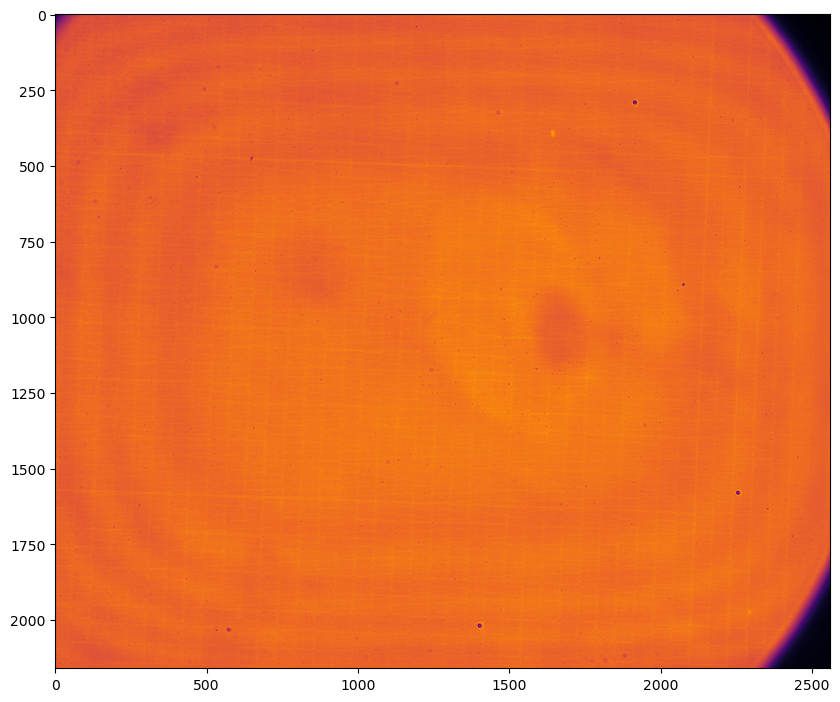

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(my_array[0],cmap='inferno')

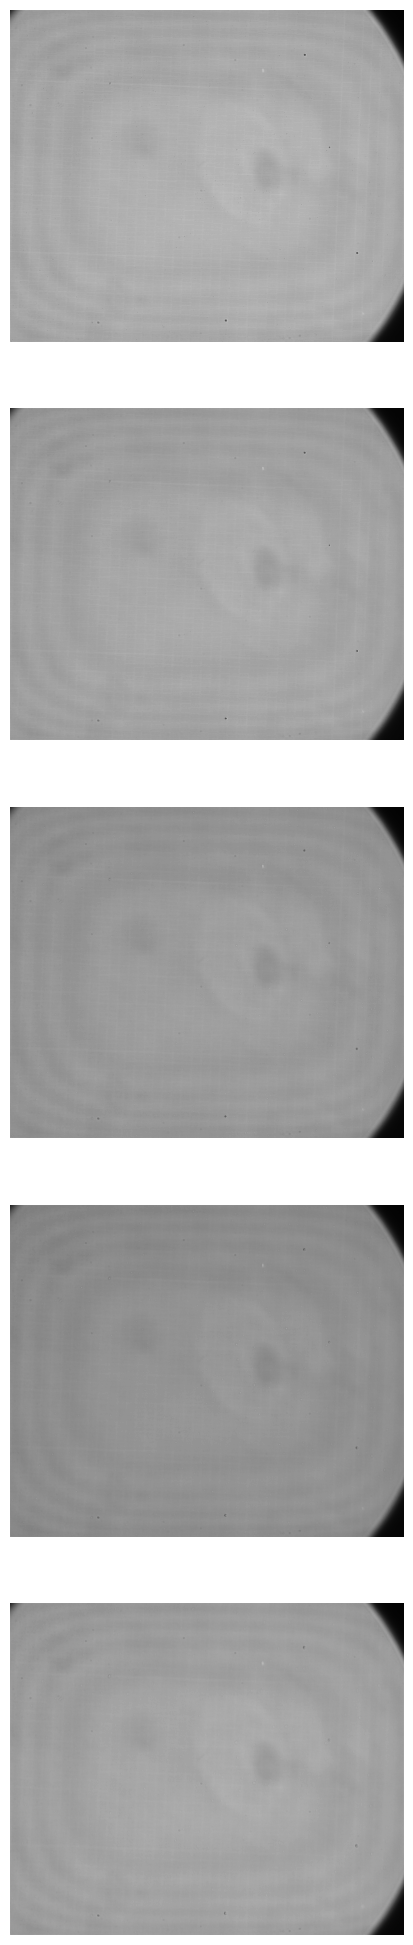

In [105]:
fig, ax = plt.subplots(5,1,figsize=(25, 25))  
a= [0,50,100,150,200]
for i in range(5):
    ax[i].imshow(my_array[a[i]],cmap='gray')
    ax[i].axis('off')
plt.show()  